In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os
import patsy

from matplotlib.colors import ListedColormap

import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN
from pysal.model import mgwr
from mgwr.sel_bw import Sel_BW

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

In [2]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

In [3]:
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}
import math
from geopandas import GeoDataFrame
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
import mcdm

In [4]:
##node1 bus stop count
sz_area=gpd.read_file('metro_data/深圳/sz_area.shp',encoding="utf-8")
sz_station=gpd.read_file('metro_data/深圳/sz_station.shp',encoding="utf-8")

In [5]:
sz_station.head()

,sid,line_name,station_na,lng,lat,lng84,lat84,geometry
0,1,??1??(???)(??--???),??,114.118666,22.532083,114.11356724559275,22.534773743036723,POINT (114.11357 22.53477)
1,2,??1??(???)(??--???),??,114.118909,22.53968,114.11381014452411,22.54237050147604,POINT (114.11381 22.54237)
2,3,??1??(???)(??--???),??,114.116939,22.544232,114.11183673025953,22.546920598243506,POINT (114.11184 22.54692)
3,4,??1??(???)(??--???),???,114.107811,22.5418,114.10269652807666,22.5444833134091,POINT (114.10270 22.54448)
4,5,??1??(???)(??--???),???,114.095173,22.540618,114.09004758727023,22.54329955667086,POINT (114.09005 22.54330)


In [6]:
sz_station.rename(columns={'sid':'id','station_na':'station_name'},inplace=True)

In [7]:
sz_area = pd.merge(sz_area, sz_station, on='id',how='left')

In [8]:
sz_area=sz_area.drop(['geometry_y'],axis=1)

In [9]:
sz_area.rename(columns={'geometry_x':'geometry'},inplace=True)

In [10]:
sz_area.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 221 entries, 0 to 220
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   time          221 non-null    int64   
 1   id            221 non-null    int64   
 2   area          221 non-null    float64 
 3   geometry      221 non-null    geometry
 4   line_name     221 non-null    object  
 5   station_name  221 non-null    object  
 6   lng           221 non-null    object  
 7   lat           221 non-null    object  
 8   lng84         221 non-null    object  
 9   lat84         221 non-null    object  
dtypes: float64(1), geometry(1), int64(2), object(6)
memory usage: 19.0+ KB


In [11]:
sz_bus_station=gpd.read_file('metro_data/深圳/amap_bus_stops_sz.shp',encoding="utf-8")
sz_bus_line=gpd.read_file('metro_data/深圳/amap_bus_lines_sz.shp',encoding="utf-8")

In [12]:
sz_bus_station_count = gpd.sjoin(sz_bus_station, sz_area, how='right')
sz_bus_station_count_test = sz_bus_station_count.groupby(['id'])['stop_id'].agg(busStop_Count='count').reset_index() 

In [13]:
sz_area = pd.merge(sz_area, sz_bus_station_count_test, on='id',how='left')

In [14]:
#service time
sz_line=gpd.read_file('metro_data/深圳/line.shp',encoding="utf-8")
sz_station_raw=gpd.read_file('metro_data/深圳/station.shp',encoding="utf-8")

In [15]:
sz_line

,line_name,start_time,end_time,start_stop,end_stop,distance,basic_pric,total_pric,geometry
0,地铁1号线(罗宝线)(罗湖--机场东),[],[],罗湖,机场东,40.33475,2,9,"LINESTRING (114.11357 22.53477, 114.11383 22.5..."
1,地铁2号线(8号线)(盐田路--赤湾),[],[],盐田路,赤湾,51.16045,2,9,"LINESTRING (114.25083 22.59182, 114.24976 22.5..."
2,地铁3号线(龙岗线)(福保--双龙),0620,2330,福保,双龙,42.86333,2,8,"LINESTRING (114.05048 22.51061, 114.04937 22.5..."
3,地铁4号线(龙华线)(福田口岸--牛湖),0630,2300,福田口岸,牛湖,30.19955,2,7,"LINESTRING (114.06413 22.51841, 114.06352 22.5..."
4,地铁5号线(环中线)(赤湾--黄贝岭),[],[],赤湾,黄贝岭,46.61984,2,7,"LINESTRING (113.89266 22.48228, 113.89203 22.4..."
5,地铁6号支线(科学城东--光明),[],[],科学城东,光明,5.42755,[],[],"LINESTRING (113.96508 22.81109, 113.96139 22.8..."
6,地铁7号线(西丽线)(太安--西丽湖),0620,2300,太安,西丽湖,29.29428,2,7,"LINESTRING (114.13205 22.57617, 114.13153 22.5..."
7,地铁9号线(梅林线)(前湾--文锦),0620,2330,前湾,文锦,35.72842,2,7,"LINESTRING (113.89086 22.52530, 113.89130 22.5..."
8,地铁10号线(坂田线)(双拥街--福田口岸),0620,2300,双拥街,福田口岸,28.8215,2,7,"LINESTRING (114.12790 22.70133, 114.12715 22.7..."
9,地铁11号线(机场线)(碧头--福田),[],[],碧头,福田,51.09669,2,10,"LINESTRING (113.81491 22.78738, 113.81490 22.7..."


In [16]:
sz_station_raw_sub=sz_station_raw[['line_name','station_na','lng']]

In [17]:
sz_area=pd.merge(sz_station_raw_sub,sz_area,on='lng',how='right')

In [18]:
sz_area=sz_area.drop(['line_name_y','station_name'],axis=1)
sz_area.rename(columns={'line_name_x':'line_name','station_na':'station_name'},inplace=True)

In [19]:
sz_line['service_time']=['990','990','1030','990','990','990','1000','1030','1000','990']

In [20]:
sz_line_sub=sz_line[['service_time','line_name']]

In [21]:
sz_area = pd.merge(sz_area, sz_line_sub, on='line_name',how='left')

In [22]:
#NODE3 service direction number
sz_area['Service_direction']=1

In [23]:
sz_area.head()

,line_name,station_name,lng,time,id,area,geometry,lat,lng84,lat84,busStop_Count,service_time,Service_direction
0,地铁1号线(罗宝线)(罗湖--机场东),罗湖,114.118666,15,1,"1,645,538.4390","POLYGON ((114.11357 22.54607, 114.11525 22.545...",22.532083,114.11356724559275,22.534773743036723,425,990,1
1,地铁1号线(罗宝线)(罗湖--机场东),国贸,114.118909,15,2,"3,369,940.4210","POLYGON ((114.11481 22.55262, 114.11581 22.551...",22.53968,114.11381014452411,22.54237050147604,768,990,1
2,地铁1号线(罗宝线)(罗湖--机场东),老街,114.116939,15,3,"3,272,737.5670","POLYGON ((114.11584 22.55701, 114.11784 22.555...",22.544232,114.11183673025953,22.546920598243506,786,990,1
3,地铁1号线(罗宝线)(罗湖--机场东),大剧院,114.107811,15,4,"3,183,149.1720","POLYGON ((114.10670 22.55365, 114.10770 22.553...",22.5418,114.10269652807666,22.5444833134091,507,990,1
4,地铁1号线(罗宝线)(罗湖--机场东),科学馆,114.095173,15,5,"3,157,301.4840","POLYGON ((114.09105 22.55413, 114.09341 22.552...",22.540618,114.09004758727023,22.54329955667086,541,990,1


In [24]:
station_list=['世界之窗','大剧院','购物公园','老街','会展中心','宝安中心','前海湾','科学馆','车公庙','岗厦','福田','市民中心','黄贝岭','赤湾','安托山','华强北','景田','后海'
             ,'少年宫','布吉','通新岭','石厦','华新','田贝','红岭','莲花村','深圳北站','红山','福民','上梅林','福田口岸','西丽','太安','前湾','五和','八卦岭','银湖','红岭北','孖岭','红树湾南']
for i in station_list:
    sz_area.Service_direction[sz_area[sz_area['station_name']==i]['Service_direction'].index.values]=2

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/envs/sds2020/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [25]:
sz_area.Service_direction[sz_area[sz_area['station_name']=='前海湾']['Service_direction'].index.values]=3
sz_area.Service_direction[sz_area[sz_area['station_name']=='车公庙']['Service_direction'].index.values]=4
sz_area.Service_direction[sz_area[sz_area['station_name']=='福田']['Service_direction'].index.values]=3
sz_area.Service_direction[sz_area[sz_area['station_name']=='深圳北站']['Service_direction'].index.values]=3
sz_area.Service_direction[sz_area[sz_area['station_name']=='福民']['Service_direction'].index.values]=3

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from

In [26]:
##node 公交线路覆盖率
road_total = pd.read_csv('metro_data/深圳/road_length.csv',low_memory=False, encoding="utf-8",
                 usecols=['road_length',"id"])
bus_line_length = pd.read_csv('metro_data/深圳/bus_line_length.csv',low_memory=False, encoding="utf-8",
                 usecols=['bus_line_length',"id"])

In [27]:
road_total = pd.merge(road_total, bus_line_length, on='id')

In [28]:
road_total['busline_Cover']=road_total.bus_line_length/road_total.road_length

In [29]:
temp=road_total[['busline_Cover','id']]

In [30]:
sz_area=pd.merge(sz_area,temp,on='id',how='left')

In [31]:
#node-对外交通道路所占比例
external_road = pd.read_csv('metro_data/深圳/external_length.csv',low_memory=False, encoding="utf-8",
                 usecols=['external_length',"id"])
external_road = pd.merge(external_road, road_total, on='id')
external_road['N_external_Coverage']=external_road.external_length/external_road.road_length
temp=external_road[['id','N_external_Coverage']]
sz_area=pd.merge(sz_area,temp,on='id',how='left')

In [32]:
sz_area.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221 entries, 0 to 220
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   line_name            221 non-null    object  
 1   station_name         221 non-null    object  
 2   lng                  221 non-null    object  
 3   time                 221 non-null    int64   
 4   id                   221 non-null    int64   
 5   area                 221 non-null    float64 
 6   geometry             221 non-null    geometry
 7   lat                  221 non-null    object  
 8   lng84                221 non-null    object  
 9   lat84                221 non-null    object  
 10  busStop_Count        221 non-null    int64   
 11  service_time         221 non-null    object  
 12  Service_direction    221 non-null    int64   
 13  busline_Cover        221 non-null    float64 
 14  N_external_Coverage  221 non-null    float64 
dtypes: float64(3), geometry

In [33]:
#Settlement-对内交通道路所占比例
internal_road = pd.read_csv('metro_data/深圳/internal_length.csv',low_memory=False, encoding="utf-8",
                 usecols=['internal_length',"id"])
internal_road = pd.merge(internal_road, road_total, on='id')
internal_road['S_internal_Coverage']=internal_road.internal_length/internal_road.road_length
temp=internal_road[['id','S_internal_Coverage']]
sz_area=pd.merge(sz_area,temp,on='id',how='left')

In [34]:
#Container 道路网密度

In [35]:
temp=road_total[['id','road_length']]
sz_area=pd.merge(temp,sz_area,on='id',how='right')

In [36]:
sz_area.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221 entries, 0 to 220
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   221 non-null    int64   
 1   road_length          221 non-null    float64 
 2   line_name            221 non-null    object  
 3   station_name         221 non-null    object  
 4   lng                  221 non-null    object  
 5   time                 221 non-null    int64   
 6   area                 221 non-null    float64 
 7   geometry             221 non-null    geometry
 8   lat                  221 non-null    object  
 9   lng84                221 non-null    object  
 10  lat84                221 non-null    object  
 11  busStop_Count        221 non-null    int64   
 12  service_time         221 non-null    object  
 13  Service_direction    221 non-null    int64   
 14  busline_Cover        221 non-null    float64 
 15  N_external_Coverage  22

In [37]:
sz_area['C_road_density']=sz_area.road_length/sz_area.area

In [38]:
#place-范围内人口总数
pop_area = pd.read_csv('metro_data/深圳/sz_pop.csv',low_memory=False, encoding="utf-8",
                 usecols=['pop',"id"])
sz_pop = pop_area.groupby(['id'])['pop'].agg(P_pop_sum='sum').reset_index()
sz_area=pd.merge(sz_pop,sz_area,on='id',how='right')

In [39]:
#node-交通用地占比/place-基本功能占比/非基本功能占比
basic_function = pd.read_csv('metro_data/深圳/sz_basic.csv',low_memory=False, encoding="utf-8",
                 usecols=['LU_area',"id"])
unbasic_function = pd.read_csv('metro_data/深圳/sz_unbasic.csv',low_memory=False, encoding="utf-8",
                 usecols=['LU_area',"id"])
transpotation_function = pd.read_csv('metro_data/深圳/sz_transpotation.csv',low_memory=False, encoding="utf-8",
                 usecols=['LU_area',"id"])

In [40]:
basic_function = basic_function.groupby(['id'])['LU_area'].agg(basic_sum='sum').reset_index()
unbasic_function = unbasic_function.groupby(['id'])['LU_area'].agg(unbasic_sum='sum').reset_index()
transpotation_function = transpotation_function.groupby(['id'])['LU_area'].agg(transpotation_sum='sum').reset_index()

In [41]:
sz_area = pd.merge(sz_area, basic_function, on='id',how='left')
sz_area = pd.merge(sz_area, unbasic_function, on='id',how='left')
sz_area = pd.merge(sz_area, transpotation_function, on='id',how='left')

In [42]:
sz_area['N_transland_Cover']=sz_area.transpotation_sum/sz_area.area
sz_area['P_basic_Cover']=sz_area.basic_sum/sz_area.area
sz_area['P_unbasic_Cover']=sz_area.unbasic_sum/sz_area.area

In [43]:
sz_area= sz_area.drop(['transpotation_sum','basic_sum','unbasic_sum'],axis=1)

In [44]:
sz_area.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221 entries, 0 to 220
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   221 non-null    int64   
 1   P_pop_sum            221 non-null    int64   
 2   road_length          221 non-null    float64 
 3   line_name            221 non-null    object  
 4   station_name         221 non-null    object  
 5   lng                  221 non-null    object  
 6   time                 221 non-null    int64   
 7   area                 221 non-null    float64 
 8   geometry             221 non-null    geometry
 9   lat                  221 non-null    object  
 10  lng84                221 non-null    object  
 11  lat84                221 non-null    object  
 12  busStop_Count        221 non-null    int64   
 13  service_time         221 non-null    object  
 14  Service_direction    221 non-null    int64   
 15  busline_Cover        22

In [45]:
sz_area['N_transland_Cover'] = sz_area['N_transland_Cover'].fillna(0)
sz_area['P_basic_Cover'] = sz_area['P_basic_Cover'].fillna(0)
sz_area['P_unbasic_Cover'] = sz_area['P_unbasic_Cover'].fillna(0)

In [46]:
#Place-Degree of landuse mix---entropy 熵 Frank（2005）
landuse_area = pd.read_csv('metro_data/深圳/sz_landuse.csv',low_memory=False, encoding="utf-8",
                 usecols=['LU_area',"id",'area','Level1'])
test = landuse_area.groupby(['id','Level1'])['LU_area'].agg(LU_sum='sum').reset_index()
test1 = pd.pivot_table(test, index='id', columns='Level1', values='LU_sum')
test2 = pd.DataFrame(test1.to_records())

In [47]:
test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      214 non-null    int64  
 1   1       209 non-null    float64
 2   2       186 non-null    float64
 3   3       135 non-null    float64
 4   4       63 non-null     float64
 5   5       209 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 10.2 KB


In [48]:
test_list=[]
for i in range (0,214):
    p=test2.loc[[i]].isna().sum().sum()
    test_list.append(p)

In [49]:
test2['na_vlaue']=test_list
test2['conf']=5
test2['n3']=test2.conf-test2.na_vlaue

In [50]:
test2['1'] = test2['1'].fillna(0)
test2['2'] = test2['2'].fillna(0)
test2['3'] = test2['3'].fillna(0)
test2['4'] = test2['4'].fillna(0)
test2['5'] = test2['5'].fillna(0)
test2['sum']=test2['1']+test2['2']+test2['3']+test2['4']+test2['5']

In [51]:
(test2['sum'] != 0).all()

True

In [52]:
LUM_list=[]
for i in range (0,214):
    if test2.at[i,'1']==0:
        t1=0
    else:
        t1=math.log(test2.at[i,'1']/test2.at[i,'sum'])
    if test2.at[i,'2']==0:
        t2=0
    else:
        t2=math.log(test2.at[i,'2']/test2.at[i,'sum'])
    if test2.at[i,'3']==0:
        t3=0
    else:
        t3=math.log(test2.at[i,'3']/test2.at[i,'sum'])
    if test2.at[i,'4']==0:
        t4=0
    else:
        t4=math.log(test2.at[i,'4']/test2.at[i,'sum'])
    if test2.at[i,'5']==0:
        t5=0
    else:
        t5=math.log(test2.at[i,'5']/test2.at[i,'sum'])
    p=(-1)*((test2.at[i,'1']/test2.at[i,'sum'])*t1
                   +(test2.at[i,'2']/test2.at[i,'sum'])*t2
                  +(test2.at[i,'3']/test2.at[i,'sum'])*t3
                  +(test2.at[i,'4']/test2.at[i,'sum'])*t4
                  +(test2.at[i,'5']/test2.at[i,'sum'])*t5)/math.log(test2.at[i,'n3'])
    LUM_list.append(p)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


In [53]:
test2['P_LUM']=LUM_list
test2['P_LUM'] = test2['P_LUM'].fillna(0)

In [54]:
LUM_df = test2[['id', 'P_LUM']]
sz_area = pd.merge(sz_area, LUM_df, on='id',how='left')

In [55]:
#place2-Simpson Diversity Index(poi)
def simpson_di(data):

    """ Given a hash { 'species': count } , returns the Simpson Diversity Index
    
    >>> simpson_di({'a': 10, 'b': 20, 'c': 30,})
    0.3888888888888889
    """

    N = sum(data.values())
    
    def p(n, N):
        """ Relative abundance """
        if n is  0:
            return 0
        else:
            return (float(n)*(n-1))/(N*(N-1))

    
    return 1-sum(p(n, N) for n in data.values() if n is not 0)

In [56]:
sz_area = GeoDataFrame(sz_area, crs="EPSG:4326", geometry=sz_area.geometry)
sz_area['P_LUM'] = sz_area['P_LUM'].fillna(0)

In [57]:
gz_area2=sz_area.copy()

In [58]:
gz_poi_cy=gpd.read_file('metro_data/深圳/poi/深圳市_餐饮.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_cy, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['id'])['gml_id'].agg(cy_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='id')

In [59]:
gz_poi_ds=gpd.read_file('metro_data/深圳/poi/深圳市_大厦.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_ds, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(ds_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [60]:
gz_poi_mall=gpd.read_file('metro_data/深圳/poi/深圳市_大型购物广场.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_mall, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(mall_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [61]:
gz_poi_gw=gpd.read_file('metro_data/深圳/poi/深圳市_购物.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_gw, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(gw_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [62]:
gz_poi_jr=gpd.read_file('metro_data/深圳/poi/深圳市_金融服务.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_jr, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(jr_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [63]:
gz_poi_ky=gpd.read_file('metro_data/深圳/poi/深圳市_科研教育.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_ky, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(ky_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [64]:
gz_poi_ly=gpd.read_file('metro_data/深圳/poi/深圳市_旅游.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_ly, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(ly_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [65]:
gz_poi_xs=gpd.read_file('metro_data/深圳/poi/深圳市_休闲娱乐.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_xs, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(xs_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [66]:
gz_poi_zf=gpd.read_file('metro_data/深圳/poi/深圳市_政府机关.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_zf, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(zf_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [67]:
gz_poi_zs=gpd.read_file('metro_data/深圳/poi/深圳市_住宿.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_zs, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(zs_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [68]:
gz_poi_zj=gpd.read_file('metro_data/深圳/poi/深圳市_宗教点.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_zj, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['station_name'])['gml_id'].agg(zj_Count='count').reset_index()
gz_area2 = pd.merge(gz_area2, gz_poi_total_count_test, on='station_name')

In [69]:
sz_area['P_poi_Diversity']=0.1

In [70]:
for i in range(0,221):
    poi_dic={'a':gz_area2['cy_Count'][i],'b':gz_area2['ds_Count'][i],'c':gz_area2['mall_Count'][i],
             'd':gz_area2['gw_Count'][i],'e':gz_area2['jr_Count'][i],'f':gz_area2['ky_Count'][i],
             'g':gz_area2['ly_Count'][i],'h':gz_area2['xs_Count'][i],'i':gz_area2['zf_Count'][i],
             'j':gz_area2['zs_Count'][i],'k':gz_area2['zj_Count'][i]}
    sz_area['P_poi_Diversity'][i]=simpson_di(poi_dic)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [71]:
sz_area['P_poi_Diversity'] = sz_area['P_poi_Diversity'].fillna(0)

In [72]:
sz_area.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 221 entries, 0 to 220
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   221 non-null    int64   
 1   P_pop_sum            221 non-null    int64   
 2   road_length          221 non-null    float64 
 3   line_name            221 non-null    object  
 4   station_name         221 non-null    object  
 5   lng                  221 non-null    object  
 6   time                 221 non-null    int64   
 7   area                 221 non-null    float64 
 8   geometry             221 non-null    geometry
 9   lat                  221 non-null    object  
 10  lng84                221 non-null    object  
 11  lat84                221 non-null    object  
 12  busStop_Count        221 non-null    int64   
 13  service_time         221 non-null    object  
 14  Service_direction    221 non-null    int64   
 15  busline_Cover  

In [73]:
#Settlement1 community_center count
gz_poi_community=gpd.read_file('metro_data/深圳/poi/深圳市_居委会点.shp',encoding="utf-8")
gz_poi_total_count = gpd.sjoin(gz_poi_community, gz_area2, how='right')
gz_poi_total_count_test = gz_poi_total_count.groupby(['id'])['gml_id'].agg(S_community_Count='count').reset_index()
sz_area = pd.merge(sz_area, gz_poi_total_count_test, on='id')

In [74]:
#container1 building height+area density
gz_building_within_area = pd.read_csv('metro_data/深圳/sz_building.csv',low_memory=False, encoding="utf-8",
                 usecols=['height','build_area',"id"])

In [75]:
gz_building_within_area['build_area'] = gz_building_within_area['build_area'].fillna(0)
gz_building_within_area['height'] = gz_building_within_area['height'].fillna(0)

In [76]:
gz_building_test = gz_building_within_area.groupby(['id'])['build_area'].agg(building_sum='sum').reset_index()
gz_building_test2 = gz_building_within_area.groupby(['id'])['height'].agg(C_height_avg='mean').reset_index()

In [77]:
sz_area = pd.merge(sz_area, gz_building_test, on='id',how='left')
sz_area = pd.merge(sz_area, gz_building_test2, on='id',how='left')

In [78]:
sz_area['building_sum'] = sz_area['building_sum'].fillna(0)
sz_area['C_height_avg'] = sz_area['C_height_avg'].fillna(0)

In [79]:
sz_area['C_building_density']=sz_area.building_sum/sz_area.area

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


In [80]:
sz_area=sz_area.drop(['building_sum'],axis=1)
sz_area.rename(columns={'busStop_Count':'N_busStop_Count',
                       'service_time':'N_service_time',
                       'Service_direction':'N_Service_direction',
                       'busline_Cover':'N_busline_Cover',},inplace=True)

In [81]:
###测量correlation
sz_cor2=sz_area.copy()
sz_cor2= sz_cor2.drop(['id','lng84','lat84','geometry','line_name','station_name','lng','lat','area','road_length','time'],axis=1)

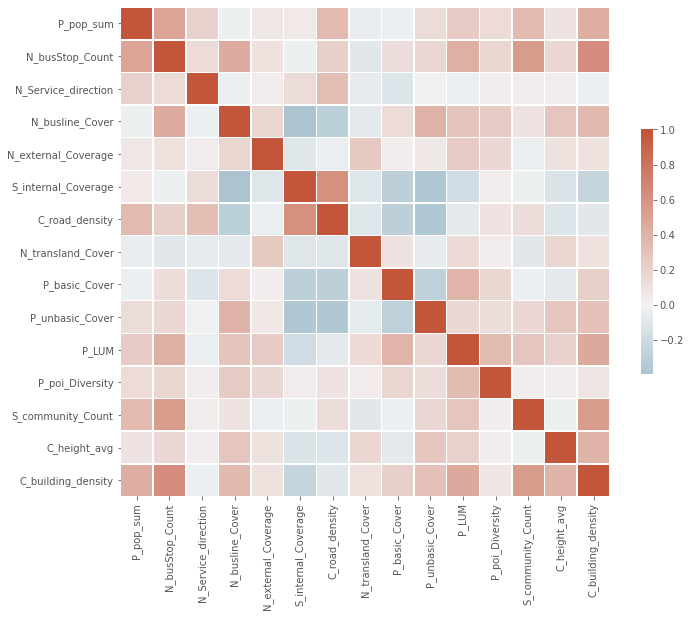

In [82]:
corrMatrix=sz_cor2.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plot1=sns.heatmap(corrMatrix,  cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [83]:
plot1.figure.savefig("corr_sz.png",dpi=300)

In [84]:
sz_area.to_csv('sz_all_variables.csv',encoding='utf-8',index=False)

In [85]:
#分析
sz_PCA=sz_area.copy()

In [86]:
sz_PCA.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 221 entries, 0 to 220
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   221 non-null    int64   
 1   P_pop_sum            221 non-null    int64   
 2   road_length          221 non-null    float64 
 3   line_name            221 non-null    object  
 4   station_name         221 non-null    object  
 5   lng                  221 non-null    object  
 6   time                 221 non-null    int64   
 7   area                 221 non-null    float64 
 8   geometry             221 non-null    geometry
 9   lat                  221 non-null    object  
 10  lng84                221 non-null    object  
 11  lat84                221 non-null    object  
 12  N_busStop_Count      221 non-null    int64   
 13  N_service_time       221 non-null    object  
 14  N_Service_direction  221 non-null    int64   
 15  N_busline_Cover

In [87]:
#PCA for Node
features_N = ['N_busStop_Count', 'N_service_time', 'N_Service_direction', 'N_busline_Cover','N_external_Coverage','N_transland_Cover'
           ]
# Separating out the features
x_N = sz_PCA.loc[:, features_N].values
# Standardizing the features
x_N =MinMaxScaler().fit_transform(x_N)#MinMaxScaler/StandardScaler

#PCA for Plcae
features_P = ['P_poi_Diversity', 'P_pop_sum', 'P_basic_Cover', 'P_unbasic_Cover','P_LUM'
           ]
# Separating out the features
x_P = sz_PCA.loc[:, features_P].values
# Standardizing the features
x_P = MaxAbsScaler().fit_transform(x_P)

#PCA for Settlement
features_S = ['S_community_Count','S_internal_Coverage'
           ]
# Separating out the features
x_S = sz_PCA.loc[:, features_S].values
# Standardizing the features
x_S = MinMaxScaler().fit_transform(x_S)

#PCA for Container
features_C = ['C_height_avg','C_building_density','C_road_density'
           ]
# Separating out the features
x_C = sz_PCA.loc[:, features_C].values
# Standardizing the features
x_C = MinMaxScaler().fit_transform(x_C)

In [88]:
Node_arry=mcdm.weighting.critic(x_N)
Node_wgt=Node_arry.tolist()
Place_arry=mcdm.weighting.critic(x_P)
Place_wgt=Place_arry.tolist()
Settlement_arry=mcdm.weighting.critic(x_S)
Settlement_wgt=Settlement_arry.tolist()
Container_arry=mcdm.weighting.critic(x_C)
Container_wgt=Container_arry.tolist()

In [89]:
###测量correlation
sz_index=sz_area.copy()
sz_index= sz_index.drop(['lng84','lat84','geometry','line_name','station_name','lng','lat','area','road_length','time','id'],axis=1)

In [90]:
sz_index.columns

Index(['P_pop_sum', 'N_busStop_Count', 'N_service_time', 'N_Service_direction',
       'N_busline_Cover', 'N_external_Coverage', 'S_internal_Coverage',
       'C_road_density', 'N_transland_Cover', 'P_basic_Cover',
       'P_unbasic_Cover', 'P_LUM', 'P_poi_Diversity', 'S_community_Count',
       'C_height_avg', 'C_building_density'],
      dtype='object')

In [91]:
scaler = MinMaxScaler()
# fit and transform the data
gz_norm = pd.DataFrame(scaler.fit_transform(sz_index), columns=sz_index.columns)

In [92]:
#计算各维度index
gz_norm['Node_index']=gz_norm.N_busStop_Count*Node_wgt[0]+gz_norm.N_service_time*Node_wgt[1]+gz_norm.N_Service_direction*Node_wgt[2]+gz_norm.N_busline_Cover*Node_wgt[3]+gz_norm.N_external_Coverage*Node_wgt[4]+gz_norm.N_transland_Cover*Node_wgt[5]
gz_norm['Place_index']=gz_norm.P_poi_Diversity*Place_wgt[0]+gz_norm.P_pop_sum*Place_wgt[1]+gz_norm.P_basic_Cover*Node_wgt[2]+gz_norm.P_unbasic_Cover*Place_wgt[3]+gz_norm.P_LUM*Place_wgt[4]
gz_norm['Settlement_index']=gz_norm.S_community_Count*Settlement_wgt[0]+gz_norm.S_internal_Coverage*Settlement_wgt[1]
gz_norm['Container_index']=gz_norm.C_height_avg*Container_wgt[0]+gz_norm.C_building_density*Container_wgt[1]+gz_norm.C_road_density*Container_wgt[2]

In [93]:
gz_final=gz_norm[['Node_index','Place_index','Settlement_index','Container_index']]
gz_final['id']=gz_final.index.values+1

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [94]:
sz_final_area=pd.merge(sz_area,gz_final,on='id',how='left')
gz_temp=sz_final_area[['id','lng','Node_index','Place_index','Settlement_index','Container_index']]

In [95]:
sz_final_area.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 221 entries, 0 to 220
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   221 non-null    int64   
 1   P_pop_sum            221 non-null    int64   
 2   road_length          221 non-null    float64 
 3   line_name            221 non-null    object  
 4   station_name         221 non-null    object  
 5   lng                  221 non-null    object  
 6   time                 221 non-null    int64   
 7   area                 221 non-null    float64 
 8   geometry             221 non-null    geometry
 9   lat                  221 non-null    object  
 10  lng84                221 non-null    object  
 11  lat84                221 non-null    object  
 12  N_busStop_Count      221 non-null    int64   
 13  N_service_time       221 non-null    object  
 14  N_Service_direction  221 non-null    int64   
 15  N_busline_Cover

In [96]:
sz_final_station=pd.merge(sz_station,gz_temp,on='id',how='left')

In [97]:
sz_final_station = sz_final_station.astype({"line_name":'string', "station_name":'string',"lat":'float64',"lng_x":'float64',"lng_y":'float64',"lat84":'float64',"lng84":'float64'})
sz_final_area = sz_final_area.astype({"line_name":'string', "station_name":'string',"lat":'float64',"lng":'float64',"lat84":'float64',"lng84":'float64',"N_service_time":'int64'})

In [98]:
sz_final_station.to_file("sz_station_withindex.shp")
sz_final_area.to_file("sz_area_withindex.shp")